# INCAWrapper validation case medium size model
This notebook serves as a validation case the show that the INCAWrapper produce similar results as a model run through the INCA GUI. Furthermore, this notebook can be used as an integration test of the INCAWrapper that can be run when changes are made to the codebase to ensure that the INCAWrapper performs consistently. This notebook is not meant as a tutorial and therefore code description is a bit more sparse. For a proper tutorial see the other examples at https://incawrapper.readthedocs.io/en/latest/examples/index.html.

## Introduction
The model we use is from Alagesan, S., Minton, N.P. & Malys, N. 13C-assisted metabolic flux analysis to investigate heterotrophic and mixotrophic metabolism in Cupriavidus necator H16. Metabolomics 14, 9 (2018). https://doi.org/10.1007/s11306-017-1302-z, which is also used for one of the tutorials.

To ensure that we can obtain a good fits to the data, we employ a simulated dataset for this validation. The simulation mimics three parallel experiment where *C. necator* is grown with different labelled fructose ([1-13C]fructose, [2-13C]fructose, and [6-13C]fructose). We simulated MS measurements of some amino acids and measurements of 4 exchanges fluxes. To increase the information in the data we added one additional reaction to the original model, i.e. CO2 -> CO2.ext. After simulating the data, we added 0.003 absolute measurement error to all MDV measurements and 0.003 relative measurement error to all flux measurements. For more details about the simulation see the file `docs/examples/Literature data/Cupriavidus necator  Alagesan 2017/c_necator_simulation.py`.

## Method for INCA GUI based flux estimation
The model, experiments and data was manually entered into the INCA GUI. This model was saved to a file (`docs/examples/Literature data/Cupriavidus necator  Alagesan 2017/c_necator_gui.mat`). We then ran first the estimate and second the continuation procedure before saving the "fluxmap" to a difference file (`docs/examples/Literature data/Cupriavidus necator  Alagesan 2017/simulated_data/c_necator_gui_fluxmap.mat`).

## Note about randomness in INCA
When INCA estimates the flux distribution it deploys an optimisation algorithm, which searches for a local optimum in the parameter space. To increase the probability that the found flux distribution is a global optimum INCA can be configured to restart the optimisation algorithm at different point in the parameter space. Unfortunately, the INCA manual do not describe any method to set the random seed for random restarts, thus the best we can do is to a large number of restarts in both the INCA GUI and the INCAWrapper to improve the probability that the two executions finds the same optimum. Therefore, we used 1000 restarts during flux estimation in both the INCAWrapper and the INCA GUI.

## Setting up the environment
First, we will setup the coding environment, load packages, set pah to files and read-in the data.

In [1]:
import pandas as pd
import numpy as np
import dotenv
import ast
import pandera as pa
import incawrapper
from incawrapper import utils
from incawrapper import visualization
import pathlib
import matplotlib.pyplot as plt
import pytest

In [2]:
# import environment variables
INCA_base_directory = dotenv.get_key(dotenv.find_dotenv(), "INCA_base_directory")

In [3]:
# set up path to data
working_dir = pathlib.Path(dotenv.find_dotenv()).parent
data_directory = working_dir / 'docs' / 'examples' / 'Literature data' / 'Cupriavidus necator  Alagesan 2017' / 'simulated_data'
results_file = data_directory / 'c_necator_incawrapper_fluxmap_non_random_rounded.mat'
gui_model_simulation_file = data_directory / 'c_necator_gui_simulation_non_random_rounded.mat'
gui_fluxmap_file = data_directory / 'c_necator_gui_fluxmap_non_random_rounded.mat'
flux_distribution_initial_guess_file = data_directory.parent / 'flux_distribution_initial_guess.txt'

In [4]:
# Reading the reactions, tracers, and simulated measurements
rxn = pd.read_csv(data_directory / 'reactions_processed.csv')
tracers = pd.read_csv(
    data_directory / 'tracer_info.csv', 
    converters={"atom_ids": ast.literal_eval, "atom_mdv": ast.literal_eval}
)
flux_measurements = pd.read_csv(data_directory / 'flux_measurements_noisy_rounded.csv')
mdv_measurements = pd.read_csv(
    data_directory / 'mdv_noisy_rounded.csv',
    converters={"labelled_atom_ids": ast.literal_eval}
)
flux_distribution_initial_guess_header = [
    'selected', 'rxn_id', 'rxn_eqn', 'Net', 'Exchange', 'Active', 'Pathway', 'Units' # true header in the GUI rxn_id = ID and rxn_eqn = Equation
]
flux_distribution_initial_guess = pd.read_csv(
    flux_distribution_initial_guess_file, 
    index_col=None,
    sep='\t',
    header=None)
flux_distribution_initial_guess.columns = flux_distribution_initial_guess_header

Looking at the traces dataframe, we can see the experimental design in this simulated dataset.

In [5]:
tracers

,experiment_id,met_id,tracer_id,atom_ids,atom_mdv,enrichment
0,simulation1,FRU.ext,D-[1-13C]fructose,[1],"[0.0, 1.0]",1
1,simulation2,FRU.ext,D-[2-13C]fructose,[2],"[0.0, 1.0]",1
2,simulation6,FRU.ext,D-[6-13C]fructose,[6],"[0.0, 1.0]",1


## Setup the INCAScript
We will now setup and run INCA. Notice that we set fit_restarts=1000, this increase the chance that the two optimization runs (GUI and INCAWrapper) find the same optimum.

In [6]:
def net_exchange_to_forward_reverse(rxn_eqn: str, net: float, exchange: float) -> tuple:
    """Converts the net and exchange fluxes to forward and reverse fluxes format for a reaction. 
    The function returns a tuple of forward and reverse fluxes. 
    
    The INCA Manual defines 
    net = v_f - v_b
    exchange = min(v_f, v_b)
    From these equations, we can derive the calculation of v_f and v_b.
    """
    if '<->' in rxn_eqn:
        if net > 0:
            v_b = exchange
            v_f = net + v_b
        elif net < 0:
            v_f = exchange
            v_b = -net + v_f
        elif net == 0.0:
            # v_f = v_b
            # v_f = v_b = exchange
            v_f = exchange
            v_b = exchange
    else:
        v_f = net
        v_b = None
    return (v_f, v_b)
    

In [7]:
# flux_distribution_initial_guess_long = (flux_distribution_initial_guess
#     .set_index(flux_distribution_initial_guess['rxn_id'])
#     .apply(
#         lambda x: net_exchange_to_forward_reverse(x['rxn_eqn'], x['Net'], x['Exchange']), 
#         axis=1
#     ).explode()
#     .reset_index()
#     .rename(columns={0: 'flux_initial_guess'})
#     .assign(rxn_id = lambda x: x['rxn_id'] + np.tile(['_f', '_b'], len(x) // 2))
#     .dropna(subset=["flux_initial_guess"])
# )
res_gui_before_estimation = incawrapper.INCAResults(gui_model_simulation_file)

flux_distribution_initial_guess_forward_reverse_format = res_gui_before_estimation.model.rates.val.values

In [8]:
script = incawrapper.create_inca_script_from_data(
    reactions_data=rxn,
    tracer_data=tracers,
    flux_measurements=flux_measurements,
    ms_measurements=mdv_measurements,
    experiment_ids=tracers.experiment_id.unique().tolist(),
)
script.add_to_block(
    block_name="model_modifications",
    matlab_script_block="""
m.rates.flx.val = ["""
    + " ".join(flux_distribution_initial_guess_forward_reverse_format.astype(str))
    + "];"
)
# Define options, the INCAWrapper leaves the remaining options at their default value
script.add_to_block(
    "options",
    incawrapper.define_options(
        fit_starts=1,
        sim_ss=True,
        sim_na=True,
        sim_more=True,
        fit_reinit=False,
    )
)

# Define what algorithm to run in INCA
script.add_to_block(
    "runner",
    incawrapper.define_runner(
        output_filename=results_file,
        run_estimate=True,
        run_continuation=False,
        run_simulation=True, # simulation has to be run otherwise the results file is invalid
    )
)

In [9]:
print(script)

clear functions

% REACTION BLOCK
% Create reactions
r = [...
reaction('FRU.ext (abcdef) -> F6P (abcdef)', 'id', 'ex_1'),...
reaction('GLY.ext (abc) -> GLY (abc)', 'id', 'ex_2'),...
reaction('GLY (abc) -> DHAP (abc)', 'id', 'R1'),...
reaction('F6P (abcdef) <-> G6P (abcdef)', 'id', 'R2'),...
reaction('F16P (abcdef) -> F6P (abcdef)', 'id', 'R4'),...
reaction('F16P (abcdef) <-> DHAP (cba) + G3P (def)', 'id', 'R5'),...
reaction('DHAP (abc) <-> G3P (abc)', 'id', 'R7'),...
reaction('G3P (abc) <-> 3PG (abc)', 'id', 'R9'),...
reaction('3PG (abc) <-> PEP (abc)', 'id', 'R11'),...
reaction('PEP (abc) <-> PYR (abc)', 'id', 'R13'),...
reaction('PYR (abc) -> ACCOA (bc) + CO2 (a)', 'id', 'R15'),...
reaction('OAA (abcd) + ACCOA (ef) -> CIT (dcbfea)', 'id', 'R16'),...
reaction('CIT (abcdef) <-> ISCIT (abcdef)', 'id', 'R17'),...
reaction('ISCIT (abcdef) -> AKG (abcde) + CO2 (f)', 'id', 'R19'),...
reaction('AKG (abcde) -> 0.5*SUCOA (bcde) + 0.5*SUCOA (edcb) + CO2 (a)', 'id', 'R20'),...
reaction('SUCOA (a

In [10]:
# run INCA
incawrapper.run_inca(
    inca_script=script,
    INCA_base_directory=INCA_base_directory,
)

INCA script saved to /var/folders/z6/mxpxh4k56tv0h0ff41vmx7gdwtlpvp/T/tmpoivhp9x1/inca_script.m.
Starting MATLAB engine...
 
ms_simulation1 = 1x23 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine232 Alanine260 Asparticacid302 Asparticacid390 Asparticacid418 Glutamicacid330 Glutamicacid432 Glycine218 Glycine246 Histidine338 Histidine440 Isoleucine274 Leucine274 Methionine320 Phenylalanine302 Phenylalanine308 Phenylalanine336 Serine362 Serine390 Threonine376 Threonine404 Valine260 Valine288
 
 
ms_simulation1 = 1x23 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
Alanine232 Alanine260 Asparticacid302 Asparticacid390 Asparticacid418 Glutamicacid330 Glutamicacid432 Glycine218 Glycine246 Histidine338 Histidine440 Isoleucine274 Leucine274 Methionine320 Phenylalanine302 Phenylalanine308 Phenylalanine336 Serine362 Serine390 Threonine376 Threonine404 Valine260 Valine288
 
 
ms_simulation1 = 1x23 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 


## Compare the results from the GUI and the INCAWRapper
Now we can read in the fit and validate that the INCAWrapper was able to find the true simulated fluxes. 

In [11]:
# read in the fitted fluxes
res = incawrapper.INCAResults(results_file)

# load the fluxmap from the GUI run
res_gui = incawrapper.INCAResults(gui_fluxmap_file)

# Print fit accepted status
print("INCA GUI goodness of fit:\n")
res_gui.fitdata.get_goodness_of_fit()
print("\n")
print("INCAWrapper goodness of fit:\n")
res.fitdata.get_goodness_of_fit()

INCA GUI goodness of fit:

Fit accepted: False
Confidence level: 0.05
Chi-square value (SSR): 58.336180961268695
Expected chi-square range: [17.53873858 48.23188959]


INCAWrapper goodness of fit:

Fit accepted: False
Confidence level: 0.05
Chi-square value (SSR): 58.33616376181975
Expected chi-square range: [17.53873858 48.23188959]


Both fits pass the goodness of fit test as the SSR-values are within the expected ranges. Let's compare the two SSR value for direct.

In [12]:
## Compare the SSR values
print("INCA GUI SSR: " + str(res_gui.fitdata.chi2))
print("INCAWrapper SSR: " + str(res.fitdata.chi2))
print("SSR difference: " + str(res_gui.fitdata.chi2 - res.fitdata.chi2))

INCA GUI SSR: 58.336180961268695
INCAWrapper SSR: 58.33616376181975
SSR difference: 1.7199448947735618e-05


The two SSR values are very similar. This means that the two solutions fit the measurements equally good.

So far the INCAWrapper and the GUI has perform comparable. Next, we will investigate the estimated parameters for the two runs.

In [13]:
raw = incawrapper.INCAResults(gui_model_simulation_file).model.raw
ms_data_tmp = pd.DataFrame.from_records(raw['expts']['data_ms'])
# for (i, idv) in ms_data_tmp.idvs.items():
#     idv.pop('base', None)
#     pd.DataFrame.from_dict(idv)
ms_data_tmp['idvs'].apply(pd.Series).drop(columns=['base']).explode('val').explode('std').drop_duplicates()

,id,norm,on,std,time,val
0,simulation1_Alanine232_inf_1,1.024826,1,0.003,inf,0.6694
0,simulation1_Alanine232_inf_1,1.024826,1,0.003,inf,0.232
0,simulation1_Alanine232_inf_1,1.024826,1,0.003,inf,0.0719
1,simulation1_Alanine260_inf_1,1.003357,1,0.003,inf,0.4388
1,simulation1_Alanine260_inf_1,1.003357,1,0.003,inf,0.3916
...,...,...,...,...,...,...
22,simulation1_Valine288_inf_1,0.998664,1,0.003,inf,0.3952
22,simulation1_Valine288_inf_1,0.998664,1,0.003,inf,0.1657
22,simulation1_Valine288_inf_1,0.998664,1,0.003,inf,0.045
22,simulation1_Valine288_inf_1,0.998664,1,0.003,inf,0.0067


In [14]:
res_gui.fitdata.measurements_and_fit_detailed

,type,expt,id,peak,time,data,std,fit,weighted residual,cont,base
0,Flux,simulation1,ex_1,[],inf,99.995600,0.300000,99.995099,-0.001670,NaN,{'id': []}
1,Flux,simulation1,ex_2,[],inf,127.014300,0.381000,127.014650,0.000919,NaN,{'id': []}
2,Flux,simulation1,R72,[],inf,22.044700,0.066100,22.044693,-0.000100,NaN,{'id': []}
3,Flux,simulation1,ex_3,[],inf,108.818600,0.326500,108.818878,0.000851,NaN,{'id': []}
4,MS,simulation1,simulation1_Alanine232_inf_1,M0,inf,0.687763,0.003082,0.687557,-0.067065,NaN,{'id': []}
...,...,...,...,...,...,...,...,...,...,...,...
91,MS,simulation1,simulation1_Valine288_inf_1,M1,inf,0.394766,0.002997,0.396556,0.597359,NaN,{'id': []}
92,MS,simulation1,simulation1_Valine288_inf_1,M2,inf,0.165518,0.002997,0.159919,-1.868494,NaN,{'id': []}
93,MS,simulation1,simulation1_Valine288_inf_1,M3,inf,0.044951,0.002997,0.049645,1.566566,NaN,{'id': []}
94,MS,simulation1,simulation1_Valine288_inf_1,M4,inf,0.006693,0.002997,0.011057,1.456278,NaN,{'id': []}


In [15]:
compare_data = pd.merge(
    # replace empty array with None
    left=(res
            .fitdata.measurements_and_fit_detailed
            .filter(['expt', 'id', 'peak', 'data'])
            .applymap(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
    ),
    right=(res_gui
            .fitdata.measurements_and_fit_detailed
            .filter(['expt', 'id', 'peak', 'data'])
            .applymap(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
    ),
    on=['expt', 'id', 'peak'],
    suffixes=('_wrapper', '_gui')
).assign(
    data_equal=lambda x: x['data_wrapper'] == x['data_gui'],
    data_diff=lambda x: x['data_wrapper'] - x['data_gui'],
    n_digits_wrapper=lambda x: x['data_wrapper'].apply(lambda x: len(str(x).split('.')[1])),
    n_digits_gui=lambda x: x['data_gui'].apply(lambda x: len(str(x).split('.')[1])),
)
compare_data.head()

,expt,id,peak,data_wrapper,data_gui,data_equal,data_diff,n_digits_wrapper,n_digits_gui
0,simulation1,R72,NaN,22.044700,22.044700,True,0.0,4,4
1,simulation1,ex_1,NaN,99.995600,99.995600,True,0.0,4,4
2,simulation1,ex_2,NaN,127.014300,127.014300,True,0.0,4,4
3,simulation1,ex_3,NaN,108.818600,108.818600,True,0.0,4,4
4,simulation1,simulation1_Alanine232_inf_1,M0,0.687763,0.687763,True,0.0,16,16


In [16]:
# Merging the two solutions in one dataframe and calculating the difference between the two solutions
fitted_parameters_compare = pd.merge(
    # the estimated norm values (the scale factor for the MDVs) has some empty arrays in some cells, these are replaced with NaNs
    left=res.fitdata.fitted_parameters.applymap(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x),
    right=res_gui.fitdata.fitted_parameters.applymap(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x),
    on=['type','id'],
    suffixes=('_from_incawrapper', '_from_gui'),
    validate='one_to_one',
).assign(
    val_diff = lambda x: np.abs(x['val_from_incawrapper'] - x['val_from_gui']),
    lb_diff = lambda x: np.abs(x['lb_from_incawrapper'] - x['lb_from_gui']),
    ub_diff = lambda x: np.abs(x['ub_from_incawrapper'] - x['ub_from_gui']),
)

Here we setup a visual comparison of the flux distributions.

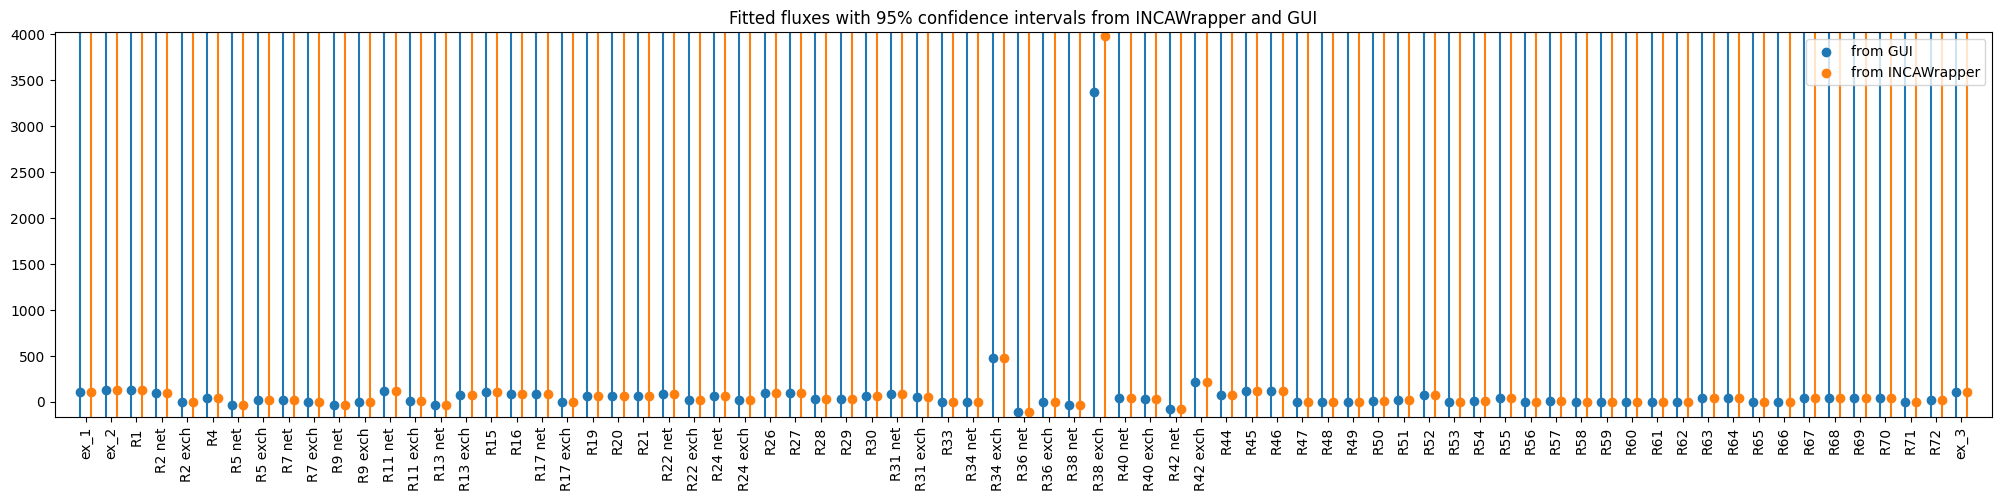

In [17]:
# set up parameters for the aestitics of the plot
data_max = fitted_parameters_compare[['val_from_incawrapper', 'val_from_gui']].max().max()
data_min = fitted_parameters_compare[['val_from_incawrapper', 'val_from_gui']].min().min()
yaxis_range = [data_min - 50, data_max + 50]
offset = 0.22

# Prepare the data for plotting. We only want to plot the fluxes 
# and the undetermined confidence interval bounds are set the the axis boundaries
plot_df = (fitted_parameters_compare
    .query("type.str.contains('flux')")
    .replace({
        'lb_from_incawrapper': {
            -np.inf: yaxis_range[0],
            np.inf: yaxis_range[0],
            np.nan: yaxis_range[0]
        },
        'lb_from_gui': {
            -np.inf: yaxis_range[0],
            np.nan: yaxis_range[0],
            np.inf: yaxis_range[0]
        },
        'ub_from_incawrapper': {
            -np.inf: yaxis_range[1],
            np.nan: yaxis_range[1],
            np.inf: yaxis_range[1]
        },
        'ub_from_gui': {
            -np.inf: yaxis_range[1],
            np.nan: yaxis_range[1],
            np.inf: yaxis_range[1]
        }
    }).copy()
)
fig, ax = plt.subplots(figsize=(25, 5))

# Create numerical ids for plotting
unique_ids = plot_df['id']
id_dict = {id: i for i, id in enumerate(unique_ids)}
plot_df['num_id'] = plot_df['id'].map(id_dict)

# Calculate error bars for both dataframes
errbars1 = plot_df[['lb_from_gui', 'ub_from_gui']].subtract(plot_df['val_from_gui'], axis=0).abs().T
errbars2 = plot_df[['lb_from_incawrapper', 'ub_from_incawrapper']].subtract(plot_df['val_from_incawrapper'], axis=0).abs().T

# Plot fitted values and error bars for the first dataframe
ax.scatter(x=plot_df['num_id'] - offset, y=plot_df['val_from_gui'], color='C0', label='from GUI')
ax.errorbar(x=plot_df['num_id'] - offset, y=plot_df['val_from_gui'], yerr=errbars1, color='C0', fmt='none')

# Plot fitted values and error bars for the second dataframe
ax.scatter(x=plot_df['num_id'] + offset, y=plot_df['val_from_incawrapper'], color='C1', label='from INCAWrapper')
ax.errorbar(x=plot_df['num_id'] + offset, y=plot_df['val_from_incawrapper'], yerr=errbars2, color='C1', fmt='none')

# Rotate x-axis labels and set them to the original string ids
ax.set_xticks(range(len(unique_ids)))
ax.set_xticklabels(unique_ids, rotation=90)

ax.legend()
ax.set_ylim(yaxis_range)
ax.set_xlim(plot_df['num_id'].min() - offset - 1, plot_df['num_id'].max() + offset + 1)
ax.set_title("Fitted fluxes with 95% confidence intervals from INCAWrapper and GUI")

plt.show()

In the plot above we see that the solution from the INCAWrapper and the INCA GUI aligns very well. For one reaction, R22 exchange, the two solutions found different values for the "best estimate" of the flux. However, both solutions finds upper bound to be non-determinable. As the flux is undeterminable we are not worried that the two best estimate flux values does not align.

Finally, we will investigate the the differences between the two estimates.

KeyError: nan

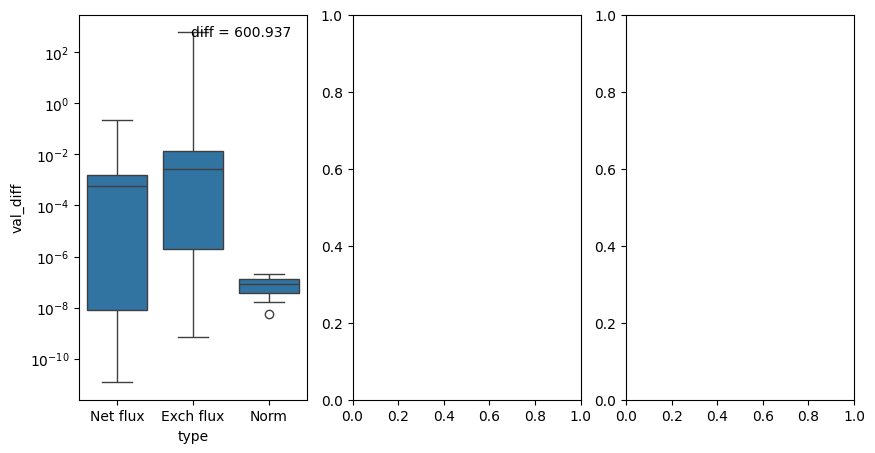

In [18]:
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, quantity in enumerate(['val', 'lb', 'ub']):
    sns.boxplot(
        data=fitted_parameters_compare.dropna(subset=[f'{quantity}_diff']), 
        x='type', 
        y=f'{quantity}_diff',
        ax=axes[i],
        log_scale=True, 
    )

    # Annotate the largest difference in the exchange fluxes
    max_diff_exch = fitted_parameters_compare.loc[fitted_parameters_compare[f'{quantity}_diff'].idxmax()]
    axes[i].annotate(
        "diff = " + str(max_diff_exch['val_diff'].round(3)),
        (max_diff_exch['type'], max_diff_exch[f'{quantity}_diff']),
        textcoords="offset points",
        xytext=(35,-3),
        ha='center',
    )
plt.tight_layout()
plt.show()

The plot above display the absolute differences between the estimates from the GUI and the INCAWrapper (left to right flux value, upper bound and lower bound). The largest difference in each quantity is annotated. Most of the the estimates values differ less than 0.1 flux units. One difference is particularly large, however, this is the R22 exchange flux, which was also discussed above.

## Conclusion
The solutions from the INCA GUI and INCAWrapper are very similar for most of the estimates the difference is below 0.1 flux units. Small differences were expected due to the lack of control of the random seed in INCA. We believe that these differences are caused by differences in the random restart positions. Thus, we conclude that the INCAWrapper functions as expected and the results obtained using the INCAWrapper are equivalent to the results obtained using the INCA GUI.